In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Se importan las librerias que se utilizaran:

In [1]:
# %tensorflow_version 1.x
import tensorflow as tf
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from random import randint
import tensorflow.keras.utils as utils
# from google.colab.patches import cv2_imshow
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD,RMSprop,Adam
from tensorflow.keras import backend as K
import itertools
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

En la etapa de obtención de datos, se recoletaron 1000 imagenes de 256x256 por cada uno de los 4 stages de cada mundo a clasificar. Es decir para el mundo 1 existe 4000 imagenes y para el mundo 2 tambien 4000 imagenes. De esta manera aseguramos un problema balanceado.

Las imagenes fueron guardadas en un arreglo de matrices de numeros que representan cada pixel de la imagen segun su codificación RGB, por esto es un arreglo de 4 dimensiones. Ademas se guardaron las imagenes en un arreglo, esto evita utilizar tiempo y recursos computacionales cada vez que se requiera ajustar parametros de la red.

Se procede a cargar los datos de las imagenes de esos archivos.

In [2]:
loaded_xarray = np.load('../Arreglos/Problema Dificil/Xnumpyarray.npy')
loaded_yarray = np.load('../Arreglos/Problema Dificil/Ynumpyarray.npy')

Se verifica que la persistencia de los datos no haya modificado las imagenes, por lo tanto se muestran aleatoriamente algunas de las imagenes cargadas.

In [3]:
def cualClase(claseBinaria):
  clase=''
  if claseBinaria==0:
    clase='Mundo 5'
  else:
    clase='Mundo 1'
  return clase

In [4]:
print('El tamaño de X es: ',loaded_xarray.shape)
print('El tamaño de Y es: ',loaded_yarray.shape)
print('Algunos de los datos.... \n')
# for i in range(20):
#   numAleatorio=randint(0,loaded_xarray.shape[0]-1)
#   print('-----------------------------------------------------')
#   print('Imagen #: ',numAleatorio ,'\n')
#   cv2_imshow(loaded_xarray[numAleatorio])
#   claseBinaria=loaded_yarray[numAleatorio]
#   clase=cualClase(claseBinaria)
#   print('Pertenece a la clase: ',clase,'\n')

El tamaño de X es:  (8280, 256, 256, 3)
El tamaño de Y es:  (8280,)
Algunos de los datos.... 



Se verifica que el problema sea balanceado

In [5]:
zeros=0
ones=0
for i in loaded_yarray:
  if i==0:
    zeros+=1
  if i==1:
    ones+=1
print('zeros: ',zeros)
print('ones: ',ones)

zeros:  4140
ones:  4140


In [ ]:
#y=loaded_yarray
#img_data = loaded_xarray.astype('float32')

Se procede a separar los datos en 20% para prueba, 10% para validación y 70% para entrenamiento. La matriz X fue importada con los datos de cada clase en orden, de la posición 0 hasta la 4139 con datos del mundo 1 y el resto con datos del mundo 2. Por lo tanto hay que aleatorizar los datos para asegurar que el modelo aprenda de ambas clases y no solamente de una.

In [6]:
x_trainval, x_test, y_trainval, y_test = train_test_split(loaded_xarray, loaded_yarray, test_size=0.2, random_state=10)
x_train, x_val, y_train, y_val = train_test_split(x_trainval, y_trainval, test_size=0.125, random_state=10)

Ya que se tienen separados los datos se proceden a definir las funciones de las metricas que se desean medir acerca de los datos y se calcularan en cada epoca. Ademas de la precisión se desea conocer el puntaje F1 y recall, que proporcionan información acerca de el sesgo del modelo sobre los datos.

In [7]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    total = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (total + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    f1=2*((precision*recall)/(precision+recall+K.epsilon()))
    return f1

Se crea la arquitectura de la red convolucional, luego se escoge la función de error con la cual se estimara el error teorico y es una función que se utiliza durante el entrenamiento, el optimizador para encontrar o estimar unos parametros que minimizen esta función de error y por ultimo las metricas, que se estiman despues del entrenamiento, es de interes la precisión empirica (numero de aciertos sobre el total), puntaje F1 y recall. La configuración de la red se muestra en el siguiente bloque:

In [13]:
model = Sequential()
model.add(Conv2D(16, (7, 7), input_shape=(256, 256, 3), activation='softmax'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
opt=RMSprop(0.00001, rho=0.9)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy', recall_m, precision_m])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 250, 250, 16)      2368      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 125, 125, 16)      0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 250000)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                16000064  
_________________________________________________________________
dense_7 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

Ahora se ajusta el modelo a los datos de entrenamiento teniendo en cuenta los datos de validación. Tambien se ajusta el numero de epocas.

In [14]:
history = model.fit(x_train, y_train, epochs=30, validation_data=(x_val, y_val))

Epoch 1/30
182/182 [==============================] - 5s 23ms/step - loss: 0.4576 - accuracy: 0.7683 - recall_m: 0.7690 - precision_m: 0.7955 - val_loss: 0.2430 - val_accuracy: 0.8357 - val_recall_m: 0.6644 - val_precision_m: 1.0000
Epoch 2/30
182/182 [==============================] - 4s 22ms/step - loss: 0.1102 - accuracy: 0.9811 - recall_m: 0.9725 - precision_m: 0.9897 - val_loss: 0.0216 - val_accuracy: 1.0000 - val_recall_m: 1.0000 - val_precision_m: 1.0000
Epoch 3/30
182/182 [==============================] - 4s 22ms/step - loss: 0.0258 - accuracy: 0.9987 - recall_m: 0.9988 - precision_m: 0.9984 - val_loss: 0.0053 - val_accuracy: 1.0000 - val_recall_m: 1.0000 - val_precision_m: 1.0000
Epoch 4/30
182/182 [==============================] - 4s 22ms/step - loss: 0.0075 - accuracy: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000 - val_loss: 0.0019 - val_accuracy: 1.0000 - val_recall_m: 1.0000 - val_precision_m: 1.0000
Epoch 5/30
182/182 [==============================] - 4s 22ms/step -

In [18]:
tf.config.list_physical_devices('GPU')
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'recall_m', 'precision_m', 'val_loss', 'val_accuracy', 'val_recall_m', 'val_precision_m'])


#Metricas sobre datos de entrenamiento y validación

# Precisión empirica 



52/52 - 0s - loss: 1.5079e-08 - accuracy: 1.0000 - recall_m: 1.0000 - precision_m: 1.0000


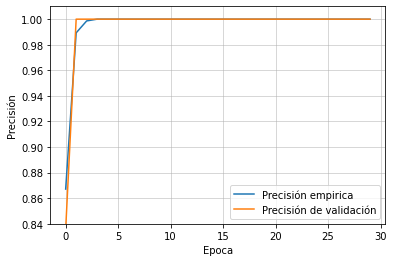

In [20]:
plt.plot(history.history['accuracy'], label='Precisión empirica')
plt.plot(history.history['val_accuracy'], label = 'Precisión de validación')
plt.xlabel('Epoca')
plt.ylabel('Precisión')
plt.grid(linewidth=0.5)
ax=plt.gca()
plt.ylim([0.84, 1.01])
plt.legend(loc='lower right')
test_loss, test_acc,f1_score,recall = model.evaluate(x_test, y_test, verbose=2)
# plt.savefig(PATH+'/drive/My Drive/Colab Notebooks/Machine Learning/Proyecto 1/Graficas/Problema Facil/precision.png')

# Funcion de error: Entropía cruzada 

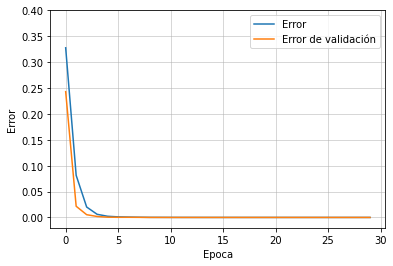

In [22]:
plt.plot(history.history['loss'], label='Error')
plt.plot(history.history['val_loss'], label = 'Error de validación')
plt.xlabel('Epoca')
plt.ylabel('Error')
plt.grid(linewidth=0.5)
ax=plt.gca()
plt.ylim([-0.02, 0.4])
plt.legend(loc='upper right')
#plt.savefig(PATH+'/drive/My Drive/Colab Notebooks/Machine Learning/Proyecto 1/Graficas/Problema Facil/Entropia Cruzada.png')
plt.show()

# F1 score 


In [ ]:
plt.plot(history.history['f1_m'], label='F1 Score')
plt.plot(history.history['val_f1_m'], label = 'Validación F1 Score')
plt.xlabel('Epoca')
plt.ylabel('F1 Score')
plt.grid(linewidth=0.5)
ax=plt.gca()
plt.ylim([0.84, 1.01])
plt.legend(loc='lower right')
#plt.savefig(PATH+'/drive/My Drive/Colab Notebooks/Machine Learning/Proyecto 1/Graficas/Problema Facil/F1 Score.png')
plt.show()

# Recall 


In [ ]:
plt.plot(history.history['recall_m'], label='Recall')
plt.plot(history.history['val_recall_m'], label = 'Validación de Recall')
plt.xlabel('Epoca')
plt.ylabel('Recall')
plt.grid(linewidth=0.5)
ax=plt.gca()
plt.ylim([0.825, 1.01])
plt.legend(loc='lower right')
plt.savefig(PATH+'/drive/My Drive/Colab Notebooks/Machine Learning/Proyecto 1/Graficas/Problema Facil/recall.png')
plt.show()

#Metricas sobre datos de prueba

In [ ]:
print('Precisión: ',test_acc)
print('Error: ',test_loss)
print('F1 score: ',f1_score)
print('Recall: ',recall)

In [ ]:
#from google.colab import output
#output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

Se utiliza el modelo entrenado para predecir los valores de Y sobre los datos de prueba, que son las predicciones del modelo. La salida de la función sigmoide es la probabilidad de pertenecer a la clase etiquetada como 1, por lo tanto establece un umbral de 0.5 para el cual si la probabilidad es mayor a 0.5, se elige la clase 1 y de lo contrario se elige la clase 0. Para esto se redondea a la cifra significativa mas cercana.

In [ ]:
predtest=model.predict(x_test)
for i in range(predtest.shape[0]):
  if predtest[i]<0.5:
    predtest[i]=0
  else:
    predtest[i]=1

Ahora se comparan los resultados sobre los datos de prueba de la predicción del modelo con respecto a las etiquetas reales de las imagenes. 


In [ ]:
for i in range(20):
  numAleatorio=randint(0,predtest.shape[0]-1)
  prediccion=predtest[numAleatorio][0]
  print('Salida de sigmoide (Predicción): ',prediccion,' que es la etiqueta de el: ',cualClase(prediccion),'\n')
  cv2_imshow(x_test[numAleatorio])
  print('\n')
  print('Etiqueta verdadera: ',y_test[numAleatorio],'que es la etiqueta de el: ', cualClase(y_test[numAleatorio]),'\n')
  if prediccion==y_test[numAleatorio]:
    print('Acierto!')
  else:
    print('Equivocado')
  print('-----------------------------------------------------')

Dada la precisión empirica de la red convolucional, la red ha podido predecir la clasificación perfectamente.

In [ ]:
filas=[]
for row_index, (input, prediction, label) in enumerate(zip (x_test, predtest, y_test)):
  if prediction != label:
    print('La imagen ', row_index, 'fue clasificada por el modelo como: ', prediction[0], 'pero pertenece a la etiqueta: ', label)

Dado que se establecio un umbral y el vector de predicciones fue binarizado, se procede analizar la matriz de confusión

In [ ]:
def plot_confusion_matrix(cm, classes, cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Etiqueta verdadera')
    plt.xlabel('Etiqueta predecida por el modelo')
    plt.title('Matriz de confusion')
    plt.tight_layout()

conf=confusion_matrix(y_test.reshape((y_test.shape[0],1)),predtest.round())
plt.figure()
plot_confusion_matrix(conf, classes=['Mundo 1','Mundo 2'])
plt.savefig(PATH+'/drive/My Drive/Colab Notebooks/Machine Learning/Proyecto 1/Graficas/Problema Facil/confusion.png')

In [ ]:
print(classification_report(y_test.reshape((y_test.shape[0],1)), predtest.round()))